In [1]:
import tika
from tika import parser
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
topics = 5

In [3]:
tika.initVM()
parsed = parser.from_file('article2.pdf')
metadados = parsed["metadata"]
texto = parsed["content"]

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [6]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [8]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [11]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
def filter_pos_tagging(data, pos):
    lista = []
    for token in data:
        for p in pos:
            if (token.pos_ == p):
                lista.append(token.text)
#                 print(token.text)

    
    return [[el] for el in lista]

In [15]:
nlp = spacy.load('en', disable=['parser', 'ner'])
mallet_path = 'mallet-2.0.8/bin/mallet' 

data = split_pdf(texto)
# print(data)

data = first_clear(data)
# print(data)

data = list(sent_to_words(data))

# Remove Stop Words
data_words_nostops = remove_stopwords(data)

aggregate = {}
list_pos = [['NOUN'], ['ADJ'], ['NOUN', 'ADJ']]

for i in range(0, len(list_pos)):
    l = []
    data_filtered = filter_pos_tagging(nlp(str(data_words_nostops)), list_pos[i] )

    bigram_mod, trigram_mod = bi_tri_gram(data_filtered)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_filtered)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                            update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)
    
    l.append(list_pos[i])
    l.append(data_lemmatized)
    l.append(id2word)
    l.append(corpus)
    l.append(lda_model)
    l.append(ldamallet)
    aggregate[i] = l

# Tópicos apenas levando em conta os Substantivos

In [16]:
pprint(aggregate[0][4].print_topics())
doc_lda = aggregate[0][4][aggregate[0][3]]

[(0,
  '0.100*"transcription" + 0.078*"foucault" + 0.057*"text" + 0.045*"note" + '
  '0.032*"mining" + 0.027*"work" + 0.023*"archive" + 0.019*"eman" + '
  '0.013*"handwriting" + 0.012*"user"'),
 (1,
  '0.086*"october" + 0.051*"humanity" + 0.049*"access" + 0.039*"search" + '
  '0.024*"character" + 0.019*"space" + 0.016*"dictionary" + '
  '0.014*"segmentation" + 0.012*"labahn" + 0.012*"folio"'),
 (2,
  '0.085*"transkribus" + 0.080*"image" + 0.075*"journal" + 0.040*"document" + '
  '0.039*"software" + 0.023*"transcribe" + 0.021*"time" + 0.019*"result" + '
  '0.018*"term" + 0.016*"transcript"'),
 (3,
  '0.058*"corpus" + 0.057*"project" + 0.050*"word" + 0.044*"manuscript" + '
  '0.044*"tool" + 0.032*"box" + 0.020*"training" + 0.018*"letter" + '
  '0.014*"model" + 0.013*"facilitate"'),
 (4,
  '0.065*"datum" + 0.038*"line" + 0.037*"network" + 0.036*"recognition" + '
  '0.028*"platform" + 0.019*"figure" + 0.019*"fuzzyquery" + 0.015*"feature" + '
  '0.015*"difficulty" + 0.014*"rate"')]


In [17]:
print('\nPerplexity: ', aggregate[0][4].log_perplexity(aggregate[0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[0][4], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.561130280412423

Coherence Score:  0.8411215390796307


In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[0][4], aggregate[0][3], aggregate[0][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.084989  0.200339       1        1  24.770079
4     -0.053884 -0.053984       2        1  21.611652
2      0.233976  0.025513       3        1  20.909252
1     -0.048231 -0.068032       4        1  17.567717
3     -0.046873 -0.103835       5        1  15.141302, topic_info=    Category       Freq           Term      Total  loglift  logprob
94   Default  61.000000  transcription  61.000000  30.0000  30.0000
3    Default  44.000000    transkribus  44.000000  29.0000  29.0000
235  Default  37.000000        october  37.000000  28.0000  28.0000
1    Default  47.000000       foucault  47.000000  27.0000  27.0000
583  Default  41.000000          image  41.000000  26.0000  26.0000
..       ...        ...            ...        ...      ...      ...
169   Topic5   2.258597    exploration   2.927799   1.6282  -5.1005
416   Topic5   1.924543         notice   2.585766   1.5924  -5.2606
249   Topic5   2.383391           path   3.254854   1.5761  -5.0468
532   Topic5   1.760589     connection   2.410147   1.5737  -5.3496
245   Topic5   2.064840  understanding   2.839411   1.5692  -5.1902

[187 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
635       4  0.869520  abbreviation
6         4  0.964861        access
432       2  0.904141       account
92        1  0.838427      addition
104       2  0.949779      analysis
...     ...       ...           ...
162       5  0.966595           way
666       5  0.836643        window
257       5  0.993193          word
74        1  0.988006          work
194       3  0.939299         write

[159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

In [19]:
pprint(aggregate[0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[0][5], texts=aggregate[0][1], dictionary=aggregate[0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.083*"transkribus" + 0.073*"journal" + 0.049*"work" + 0.045*"access" + '
  '0.043*"october" + 0.028*"order" + 0.028*"reference" + 0.022*"annotation" + '
  '0.020*"training" + 0.016*"produce"'),
 (1,
  '0.076*"document" + 0.072*"archive" + 0.060*"text" + 0.054*"corpus" + '
  '0.050*"line" + 0.039*"word" + 0.037*"box" + 0.031*"bnf" + 0.027*"team" + '
  '0.014*"write"'),
 (2,
  '0.089*"transcription" + 0.062*"note" + 0.041*"humanity" + 0.039*"tool" + '
  '0.035*"recognition" + 0.031*"manuscript" + 0.029*"software" + '
  '0.025*"search" + 0.023*"lecture" + 0.021*"model"'),
 (3,
  '0.093*"image" + 0.066*"project" + 0.040*"transcribe" + 0.038*"time" + '
  '0.038*"mining" + 0.032*"source" + 0.023*"handwriting" + 0.021*"figure" + '
  '0.021*"user" + 0.019*"character"'),
 (4,
  '0.195*"foucault" + 0.071*"datum" + 0.041*"note" + 0.034*"platform" + '
  '0.026*"text" + 0.026*"manuscript" + 0.021*"network" + 0.019*"information" + '
  '0.017*"test" + 0.015*"france"')]

Coherence Score:  0.8

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[0][2], corpus=aggregate[0][3], texts=aggregate[0][1], start=2, limit=40, step=6)


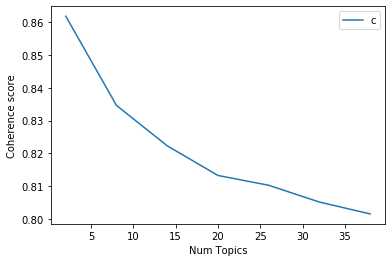

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos apenas levando em conta os Adjetivos


In [22]:
pprint(aggregate[1][4].print_topics())
doc_lda = aggregate[1][4][aggregate[1][3]]

[(0,
  '0.183*"digital" + 0.134*"new" + 0.037*"handwritten" + 0.035*"additional" + '
  '0.029*"average" + 0.028*"complex" + 0.028*"philosophical" + '
  '0.025*"methodological" + 0.023*"accurate" + 0.020*"limit"'),
 (1,
  '0.133*"automatic" + 0.042*"several" + 0.037*"collaborative" + 0.036*"main" '
  '+ 0.033*"able" + 0.029*"particular" + 0.029*"nationale" + 0.028*"certain" + '
  '0.028*"available" + 0.023*"rdfs"'),
 (2,
  '0.140*"issn" + 0.088*"first" + 0.078*"large" + 0.063*"different" + '
  '0.036*"full" + 0.030*"original" + 0.029*"michel" + 0.027*"common" + '
  '0.014*"systematic" + 0.014*"public"'),
 (3,
  '0.128*"open" + 0.107*"possible" + 0.075*"neural" + 0.038*"general" + '
  '0.037*"next" + 0.035*"easy" + 0.028*"archive" + 0.027*"international" + '
  '0.027*"complementary" + 0.024*"fuzzy"'),
 (4,
  '0.163*"online" + 0.062*"historical" + 0.041*"difficult" + 0.033*"strauss" + '
  '0.032*"necessary" + 0.026*"specific" + 0.023*"second" + 0.019*"regular" + '
  '0.019*"better" + 0.01

In [23]:
print('\nPerplexity: ', aggregate[1][4].log_perplexity(aggregate[1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[1][4], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.1798537140539676

Coherence Score:  0.8414052754670006


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[1][4], aggregate[1][3], aggregate[1][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.122453  0.223526       1        1  23.633984
0     -0.267755  0.050193       2        1  21.485762
1      0.047804 -0.102117       3        1  20.960558
3      0.056727 -0.128737       4        1  17.255630
2      0.040771 -0.042865       5        1  16.664070, topic_info=    Category       Freq        Term      Total  loglift  logprob
8    Default  26.000000     digital  26.000000  30.0000   30.000
17   Default  25.000000      online  25.000000  29.0000   29.000
20   Default  19.000000         new  19.000000  28.0000   28.000
23   Default  18.000000   automatic  18.000000  27.0000   27.000
25   Default  15.000000        issn  15.000000  26.0000   26.000
..       ...        ...         ...        ...      ...      ...
152   Topic5   0.606513  ingenierie   1.184455   1.1226   -5.182
117   Topic5   0.606513   stylistic   1.184455   1.1226   -5.182
149   Topic5   0.606513         uri   1.184455   1.1226   -5.182
134   Topic5   0.606513   classical   1.184455   1.1226   -5.182
128   Topic5   0.606513    samantha   1.184455   1.1226   -5.182

[194 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
219       3  0.977947        able
212       2  0.686925  accessible
195       2  0.800736    accurate
193       2  0.919146  additional
246       1  0.933551    american
...     ...       ...         ...
149       5  0.844270         uri
235       3  0.548154      usable
122       3  0.819843     various
223       3  0.548154     visible
226       3  0.548154        wise

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

In [25]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[1][5], texts=aggregate[1][1], dictionary=aggregate[1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.222*"automatic" + 0.100*"difficult" + 0.089*"original" + '
  '0.044*"important" + 0.033*"initial" + 0.033*"impossible" + '
  '0.022*"complementary" + 0.022*"bibliographical" + 0.022*"hierarchical" + '
  '0.011*"systematic"'),
 (1,
  '0.221*"digital" + 0.142*"online" + 0.080*"michel" + 0.044*"general" + '
  '0.035*"main" + 0.027*"correct" + 0.027*"previous" + 0.027*"illegible" + '
  '0.018*"interesting" + 0.018*"strauss"'),
 (2,
  '0.070*"collaborative" + 0.050*"easy" + 0.050*"philosophical" + '
  '0.050*"multiple" + 0.050*"methodological" + 0.050*"average" + '
  '0.050*"significant" + 0.040*"full" + 0.040*"common" + 0.030*"complex"'),
 (3,
  '0.140*"issn" + 0.066*"specific" + 0.066*"digital" + 0.058*"historical" + '
  '0.058*"handwritten" + 0.041*"heterogeneous" + 0.041*"rdfs" + 0.025*"fuzzy" '
  '+ 0.025*"national" + 0.025*"neural"'),
 (4,
  '0.198*"open" + 0.094*"large" + 0.083*"archive" + 0.052*"nationale" + '
  '0.042*"personal" + 0.031*"intellectual" + 0.031*"creative" +

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[1][2], corpus=aggregate[1][3], texts=aggregate[1][1], start=2, limit=40, step=6)


In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos levando em conta os Adjetivos e Substantivos


In [27]:
pprint(aggregate[2][4].print_topics())
doc_lda = aggregate[2][4][aggregate[2][3]]

[(0,
  '0.048*"project" + 0.040*"issn" + 0.021*"handwriting" + 0.018*"historical" + '
  '0.018*"time" + 0.016*"france" + 0.014*"example" + 0.013*"dictionary" + '
  '0.011*"difficult" + 0.011*"system"'),
 (1,
  '0.076*"transkribus" + 0.051*"humanity" + 0.050*"access" + 0.041*"open" + '
  '0.034*"document" + 0.025*"possible" + 0.023*"difficulty" + 0.021*"box" + '
  '0.017*"org" + 0.016*"space"'),
 (2,
  '0.079*"datum" + 0.069*"image" + 0.050*"note" + 0.043*"archive" + '
  '0.041*"network" + 0.035*"software" + 0.034*"word" + 0.018*"neural" + '
  '0.016*"overview" + 0.014*"training"'),
 (3,
  '0.053*"transcription" + 0.035*"online" + 0.030*"text" + 0.028*"tool" + '
  '0.028*"corpus" + 0.025*"automatic" + 0.023*"mining" + 0.023*"manuscript" + '
  '0.019*"line" + 0.018*"new"'),
 (4,
  '0.097*"foucault" + 0.084*"journal" + 0.076*"october" + 0.070*"digital" + '
  '0.029*"transcribe" + 0.016*"figure" + 0.013*"rate" + 0.013*"letter" + '
  '0.012*"able" + 0.009*"abbreviation"')]


In [28]:
print('\nPerplexity: ', aggregate[2][4].log_perplexity(aggregate[2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=aggregate[2][4], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.948841153131437

Coherence Score:  0.8416810623086814


In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(aggregate[2][4], aggregate[2][3], aggregate[2][2])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.238959 -0.009841       1        1  33.202564
0     -0.045973  0.016347       2        1  18.024708
1     -0.057585  0.043902       3        1  16.431812
4     -0.060572  0.130408       4        1  16.319319
2     -0.074829 -0.180816       5        1  16.021595, topic_info=     Category       Freq           Term      Total  loglift  logprob
1     Default  49.000000       foucault  49.000000  30.0000  30.0000
45    Default  43.000000        journal  43.000000  29.0000  29.0000
46    Default  39.000000          datum  39.000000  28.0000  28.0000
300   Default  39.000000        october  39.000000  27.0000  27.0000
3     Default  39.000000    transkribus  39.000000  26.0000  26.0000
...       ...        ...            ...        ...      ...      ...
167    Topic5   1.085971         detail   1.691359   1.3882  -6.1242
410    Topic5   1.150500        problem   1.844665   1.3591  -6.0664
315    Topic5   1.658762  understanding   2.853972   1.2886  -5.7006
1083   Topic5   1.489358          scott   9.267254   0.0031  -5.8083
1059   Topic5   1.497900     fuzzyquery   9.830067  -0.0501  -5.8026

[191 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
819       4  0.934870  abbreviation
914       4  0.824808          able
9         3  0.969106        access
563       2  0.952896       account
840       2  0.823933    additional
...     ...       ...           ...
606       2  0.921114          user
199       2  0.891600           way
861       3  0.674316        window
335       5  0.971159          word
93        1  0.993332          work

[171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

In [30]:
pprint(aggregate[1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=aggregate[2][5], texts=aggregate[2][1], dictionary=aggregate[2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.222*"automatic" + 0.100*"difficult" + 0.089*"original" + '
  '0.044*"important" + 0.033*"initial" + 0.033*"impossible" + '
  '0.022*"complementary" + 0.022*"bibliographical" + 0.022*"hierarchical" + '
  '0.011*"systematic"'),
 (1,
  '0.221*"digital" + 0.142*"online" + 0.080*"michel" + 0.044*"general" + '
  '0.035*"main" + 0.027*"correct" + 0.027*"previous" + 0.027*"illegible" + '
  '0.018*"interesting" + 0.018*"strauss"'),
 (2,
  '0.070*"collaborative" + 0.050*"easy" + 0.050*"philosophical" + '
  '0.050*"multiple" + 0.050*"methodological" + 0.050*"average" + '
  '0.050*"significant" + 0.040*"full" + 0.040*"common" + 0.030*"complex"'),
 (3,
  '0.140*"issn" + 0.066*"specific" + 0.066*"digital" + 0.058*"historical" + '
  '0.058*"handwritten" + 0.041*"heterogeneous" + 0.041*"rdfs" + 0.025*"fuzzy" '
  '+ 0.025*"national" + 0.025*"neural"'),
 (4,
  '0.198*"open" + 0.094*"large" + 0.083*"archive" + 0.052*"nationale" + '
  '0.042*"personal" + 0.031*"intellectual" + 0.031*"creative" +

In [31]:
model_list, coherence_values = compute_coherence_values(dictionary=aggregate[2][2], corpus=aggregate[2][3], texts=aggregate[2][1], start=2, limit=40, step=6)


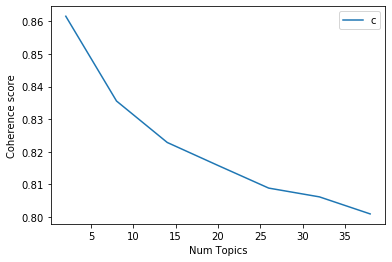

In [32]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()